In [1]:
!pip install noisereduce
import torch
import torch.nn as nn
import torch.optim as optim
import librosa
import librosa.display
import numpy as np
import os
import IPython.display as ipd
import noisereduce as nr

In [2]:
device = None
dtype = torch.float32
if torch.cuda.is_available():
  device = torch.device('cuda')
else: device = torch.device('cpu')

In [3]:
!git clone https://github.com/soerenab/AudioMNIST.git

Cloning into 'AudioMNIST'...
remote: Enumerating objects: 30119, done.
remote: Total 30119 (delta 0), reused 0 (delta 0), pack-reused 30119
Receiving objects: 100% (30119/30119), 944.54 MiB | 21.31 MiB/s, done.
Resolving deltas: 100% (26/26), done.
Checking out files: 100% (30018/30018), done.


In [4]:
data, sr = librosa.load('AudioMNIST/data/01/0_01_0.wav',mono=True, sr=None)

In [5]:
data.shape

(35877,)

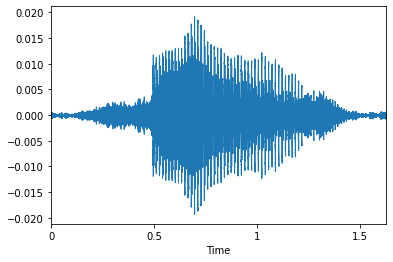

In [6]:
librosa.display.waveplot(data)

In [7]:
X = librosa.stft(data)

Xdb = librosa.amplitude_to_db(abs(librosa.stft(data)))

In [287]:
Xdb.shape

(1025, 71)

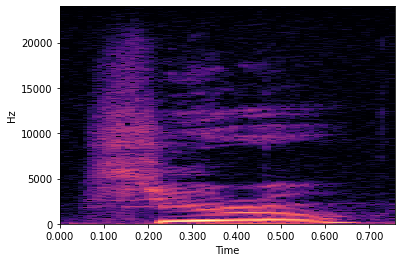

In [8]:
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')

In [9]:
!pip install torchaudio
import torchaudio
import matplotlib.pyplot as plt

     |████████████████████████████████| 1.9 MB 3.9 MB/s 


torch.Size([1, 35877]) <built-in method type of Tensor object at 0x7f9900266d20>
48000


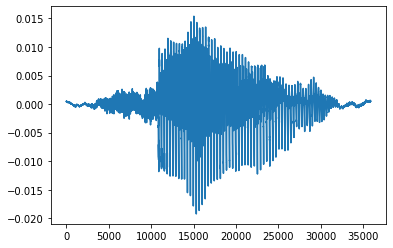

In [10]:
file = 'AudioMNIST/data/01/0_01_0.wav'
audio, sr = torchaudio.load(file)
print(audio.size(), audio.type) 
print(sr)
plt.plot(audio.t().numpy())

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:433: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "
/usr/local/lib/python3.7/dist-packages/torch/functional.py:472: UserWarning: stft will soon require the return_complex parameter be given for real inputs, and will further require that return_complex=True in a future PyTorch release. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:664.)
  normalized, onesided, return_complex)


The slowest run took 59.93 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 5: 832 µs per loop
torch.Size([1, 128, 180])


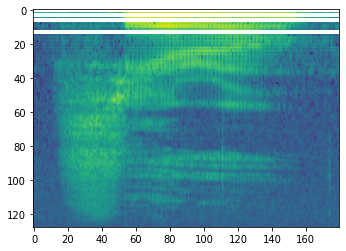

In [11]:
specgram = torchaudio.transforms.MelSpectrogram()(audio)
%timeit torchaudio.transforms.AmplitudeToDB(abs(torch.stft(audio, 4))) #clearly way faster than librosa
print(specgram.size())

plt.figure()
p = plt.imshow(specgram.log2()[0,:,:].detach().numpy())

In [12]:
audio = []
dir = 'AudioMNIST/data/'
#dir = 'free-spoken-digit-dataset/recordings'

for (root,dirs,files) in os.walk(dir):
  for file in files:
    if file.endswith('.wav'):
      path = root+'/'+file
      audio.append(path) #appends [data, sampling rate to audio]
      print(path)
    
      

Streaming output truncated to the last 5000 lines.
AudioMNIST/data/44/7_44_3.wav
AudioMNIST/data/44/9_44_18.wav
AudioMNIST/data/44/5_44_37.wav
AudioMNIST/data/44/5_44_39.wav
AudioMNIST/data/44/6_44_39.wav
AudioMNIST/data/44/0_44_46.wav
AudioMNIST/data/44/5_44_30.wav
AudioMNIST/data/44/4_44_30.wav
AudioMNIST/data/44/4_44_36.wav
AudioMNIST/data/44/3_44_48.wav
AudioMNIST/data/44/9_44_21.wav
AudioMNIST/data/44/7_44_36.wav
AudioMNIST/data/44/1_44_44.wav
AudioMNIST/data/44/3_44_16.wav
AudioMNIST/data/44/5_44_43.wav
AudioMNIST/data/44/8_44_33.wav
AudioMNIST/data/44/2_44_38.wav
AudioMNIST/data/44/8_44_21.wav
AudioMNIST/data/44/3_44_37.wav
AudioMNIST/data/44/4_44_19.wav
AudioMNIST/data/44/3_44_26.wav
AudioMNIST/data/44/9_44_3.wav
AudioMNIST/data/44/8_44_23.wav
AudioMNIST/data/44/1_44_32.wav
AudioMNIST/data/44/9_44_41.wav
AudioMNIST/data/44/6_44_9.wav
AudioMNIST/data/44/8_44_7.wav
AudioMNIST/data/44/4_44_4.wav
AudioMNIST/data/44/5_44_23.wav
AudioMNIST/data/44/1_44_14.wav
AudioMNIST/data/44/4_44_

In [13]:
from tensorflow import keras

In [14]:
#audio
#keras.utils.to_categorical

In [273]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
import sys
from matplotlib import cm

class DataGenerator:
  def __init__(self, dataset, max_len = 40):
    if dataset == "AudioMNIST":
      path = 'AudioMNIST/data/'
    elif dataset == 'freespeak': path = 'free-spoken-digit-dataset/recordings'
    self.path = path
    self.dataset = dataset;
    self.max_len = max_len
    print(path)

  def process_audio(self, file, root = None):
    '''
    returns audio's mfccs: 
    '''
    max_len = self.max_len;
    if root is None:
      path = os.path.join(self.path, file)
    else:
      path = os.path.join(root, file)
    wave, sr = librosa.load(path, mono=True, sr=None)
    wave = wave[::3]
    mfcc = librosa.feature.mfcc(wave, sr=8000)
    #chroma_stft = librosa.feature.chroma_stft(wave, sr=8000)
    
    pad_width = max_len - mfcc.shape[1]
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')

    #pad_width_chroma_stft = max_len - chroma_stft.shape[1]
    #chroma_stft = np.pad(chroma_stft, pad_width=((0, 8), (0, pad_width_chroma_stft)), mode='constant')
    return mfcc
    #wave, sr = torchaudio.load_wav(path)
    # shifting to pytorch
    # mel = torchaudio.transform.MelSpectrogram(wave, )
    # pad_width = max_len - mel.shape[1]
    # mel_padded = 

    # return mel_padded

  def __get_data(self):
    '''returns audio files after extracting mfc features and categorical labels'''
    label = []
    data = []
    dir = self.path
    i=0
    
    for (root,dirs,files) in os.walk(dir):
      for file in files:
        i+=1
        if file.endswith('.wav'):
          data.append(self.process_audio(file, root = root))
          
          label.append(file.split('_')[0][0])
          sys.stdout.write("\rDoing thing %i" % i)
          sys.stdout.flush()
    return np.asarray(data), keras.utils.to_categorical(label)

  def get_data(self, test_size = 0.1, val_size = 0.1):
    data, labels = self.__get_data()
    X, X_test, y, y_test = train_test_split(data, labels, test_size=test_size, random_state = 1)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_size, random_state = 2)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [274]:
dataset = DataGenerator('AudioMNIST') 

X_train, X_val, X_test, y_train, y_val, y_test = dataset.get_data(test_size = 0.1, val_size = 0.111)

AudioMNIST/data/
Doing thing 30001

In [275]:
import pickle

In [276]:
X_train.shape

(24003, 20, 40)

In [277]:

data = {
    'X_train': X_train, 'y_train': y_train,
    'X_test': X_test, 'y_test':y_test,
    'X_val': X_val, 'y_val': y_val
}
for key in data.keys():
  mat = data[key]
  pickle.dump( mat, open( "Data/"+key+".pkl", "wb" ) )

In [20]:
#new_data = pickle.load(open('Data/X_train.pkl', 'rb'))
#new_data = np.reshape(new_data, (2000, 20, 20))
#assert (new_data == X_train).all()

In [21]:
!zip -r file.zip Data
from google.colab import files
files.download("file.zip")

  adding: Data/ (stored 0%)
  adding: Data/X_val.pkl (deflated 50%)
  adding: Data/y_train.pkl (deflated 97%)
  adding: Data/X_train.pkl (deflated 50%)
  adding: Data/y_val.pkl (deflated 97%)
  adding: Data/X_test.pkl (deflated 50%)
  adding: Data/y_test.pkl (deflated 97%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
#For loading data from colab
'''
import pickle
data={}
keys = 'X_train, X_val, X_test, y_train, y_val, y_test'.split(', ')
for key in keys:
  path = '/content/drive/My Drive/Stride/audio/Data/' #"Data/"
  mat = pickle.load( open( path +key+".pkl", "rb" ) )
  data.update({key : mat} )

X_train, X_val, X_test, y_train, y_val, y_test = [y for y in data.values()]
'''

'\nimport pickle\ndata={}\nkeys = \'X_train, X_val, X_test, y_train, y_val, y_test\'.split(\', \')\nfor key in keys:\n  path = \'/content/drive/My Drive/Stride/audio/Data/\' #"Data/"\n  mat = pickle.load( open( path +key+".pkl", "rb" ) )\n  data.update({key : mat} )\n\nX_train, X_val, X_test, y_train, y_val, y_test = [y for y in data.values()]\n'

In [23]:
#import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU

#from ann_visualizer.visualize import ann_viz

def get_cnn_model(input_shape, num_classes, d = 0.2):
  model = Sequential()
  #model.add(Input(shape= (20,20,1) ))
  #conv
  model.add(Conv2D(32, kernel_size=3,  input_shape = input_shape)) #18
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.05))
  model.add(Dropout(d))
  #conv
  model.add(Conv2D(64, kernel_size=3)) #16
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.05))
  model.add(Dropout(d))
  #pool
  model.add(Conv2D(32, kernel_size=2, strides = 2)) #8
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.05))
  #model.add(Dropout(d))
  #conv
  model.add(Conv2D(64, kernel_size=5, padding = 'same')) #8
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.05))
  model.add(Dropout(d))
  #conv
  model.add(Conv2D(128, kernel_size=3, padding = 'same')) #8
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.05))
  model.add(Dropout(d))
  #pool
  model.add(Conv2D(128, kernel_size=2, strides = 2, activation='relu')) #2
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.05))
  #model.add(Dropout(d))

  model.add(Flatten())
  #2 x FC
  model.add(Dense(256))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.05))
  model.add(Dropout(d))
  model.add(Dense(100))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.05))
  model.add(Dropout(d))
  model.add(Dense(num_classes, activation='softmax'))

  #model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])
  
  return model


In [278]:
#model params and minor reshaping
dim = X_train.shape[1]
assert dim == 20
channels =1
X_train = X_train.reshape((X_train.shape[0], dim, 40, channels))
X_val = X_val.reshape((X_val.shape[0], dim, 40, channels))
X_test = X_test.reshape((X_test.shape[0], dim, 40, channels))
input_shape = (dim, 40, 1)
classes = 10

In [279]:
X_train.shape

(24003, 20, 40, 1)

In [280]:
#import keras
#from keras.optimizers import Adam
!nvidia-smi

Fri Aug 20 17:24:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    58W / 149W |    797MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [27]:
model = get_cnn_model(input_shape, classes) #, 0.4
opt = keras.optimizers.Adam(learning_rate=1e-3)#, decay = 0.95)
# model.compile(optimizer=opt,
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=64, epochs=50, 
                    validation_data=(X_val, y_val), verbose = 1)

Epoch 1/50
376/376 [==============================] - 42s 31ms/step - loss: 0.2767 - accuracy: 0.9197 - val_loss: 0.0223 - val_accuracy: 0.9960
Epoch 2/50
376/376 [==============================] - 11s 30ms/step - loss: 0.0534 - accuracy: 0.9853 - val_loss: 0.0151 - val_accuracy: 0.9960
Epoch 3/50
376/376 [==============================] - 11s 30ms/step - loss: 0.0462 - accuracy: 0.9865 - val_loss: 0.0162 - val_accuracy: 0.9950
Epoch 4/50
376/376 [==============================] - 11s 30ms/step - loss: 0.0318 - accuracy: 0.9910 - val_loss: 0.0174 - val_accuracy: 0.9957
Epoch 5/50
376/376 [==============================] - 11s 30ms/step - loss: 0.0118 - accuracy: 0.9970 - val_loss: 0.0088 - val_accuracy: 0.9980
Epoch 6/50
376/376 [==============================] - 11s 30ms/step - loss: 0.0109 - accuracy: 0.9976 - val_loss: 0.0093 - val_accuracy: 0.9970
Epoch 7/50
376/376 [==============================] - 11s 30ms/step - loss: 0.0196 - accuracy: 0.9948 - val_loss: 0.0120 - val_accuracy:

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 18, 38, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 18, 38, 32)        128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 18, 38, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 18, 38, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 36, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 36, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 36, 64)        0

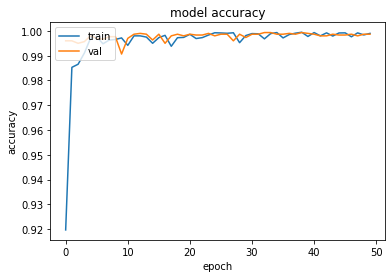

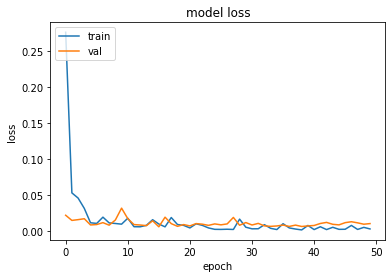

In [29]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [30]:
model.evaluate(X_test, y_test, batch_size=64)

47/47 [==============================] - 1s 14ms/step - loss: 0.0027 - accuracy: 0.9987


[0.002743469551205635, 0.9986666440963745]

In [31]:
model.save_weights('model_weights.h5')

### Manual check on test set


In [32]:
X_test[2].shape

(20, 40, 1)

In [33]:
y_test[2]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

In [34]:
dd = []
dd.append(X_test[2])
nd = np.asarray(dd)
del dd

In [35]:
nd.shape

(1, 20, 40, 1)

In [38]:
model.predict(nd).argmax()

7

# Test on given file

In [300]:
data, sr = librosa.load('/content/drive/MyDrive/Stride/VICTIM-AUDIO-ACUITY-TEST.mp3')
data = nr.reduce_noise(y=data, sr=sr)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


  0%|          | 0/8 [00:00<?, ?it/s]

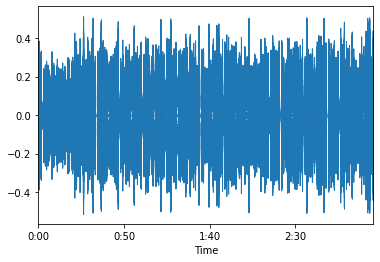

In [302]:
librosa.display.waveplot(data)

In [303]:
data.shape

(4309056,)

In [304]:
file = '/content/drive/MyDrive/Stride/VICTIM-AUDIO-ACUITY-TEST.mp3'
audio, sr = torchaudio.load(file)

In [305]:
audio.shape

torch.Size([1, 4308480])

In [306]:
!pip install pydub
from pydub import AudioSegment
from pydub.silence import split_on_silence

#def match_target_amplitude(aChunk, target_dBFS):
#   ''' Normalize given audio chunk '''
#    change_in_dBFS = target_dBFS - aChunk.dBFS
#    return aChunk.apply_gain(change_in_dBFS)

song = AudioSegment.from_mp3(file)

In [307]:
song

In [308]:
chunks = split_on_silence (
    # Use the loaded audio.
    song, 
    # Specify that a silent chunk must be at least 2 seconds or 2000 ms long.
    min_silence_len = 600,
    # Consider a chunk silent if it's quieter than -16 dBFS.
    # (You may want to adjust this parameter.)
    silence_thresh = -40
)

In [309]:
len(chunks)

116

In [97]:
#chunks[1].export("filename.wav", format="wav") #to save as mp3/mp4

In [98]:
chunks[1]

In [310]:
for i in range(len(chunks)):
 chunks[i].export(f"new_data/{i}.wav", format="wav")



In [313]:
# saving after filtering data

p=0
chunks1 = []
for i in range(len(chunks)):
  if chunks[i].duration_seconds < 1:
    chunks1.append(chunks[i])
    chunks[i].export(f"new_data1/{p}.wav", format="wav")
    p += 1
  #print(i,chunks[i].duration_seconds)

In [314]:
len(chunks1)

81

In [315]:
!zip -r new_data1.zip new_data1
from google.colab import files
files.download("new_data1.zip")

updating: new_data1/ (stored 0%)
updating: new_data1/32.wav (deflated 9%)
updating: new_data1/1.wav (deflated 11%)
updating: new_data1/12.wav (deflated 26%)
updating: new_data1/60.wav (deflated 22%)
updating: new_data1/55.wav (deflated 19%)
updating: new_data1/79.wav (deflated 12%)
updating: new_data1/10.wav (deflated 9%)
updating: new_data1/58.wav (deflated 21%)
updating: new_data1/74.wav (deflated 11%)
updating: new_data1/38.wav (deflated 11%)
updating: new_data1/3.wav (deflated 8%)
updating: new_data1/34.wav (deflated 27%)
updating: new_data1/19.wav (deflated 19%)
updating: new_data1/26.wav (deflated 12%)
updating: new_data1/59.wav (deflated 11%)
updating: new_data1/31.wav (deflated 12%)
updating: new_data1/66.wav (deflated 17%)
updating: new_data1/13.wav (deflated 8%)
updating: new_data1/15.wav (deflated 11%)
updating: new_data1/25.wav (deflated 24%)
updating: new_data1/70.wav (deflated 24%)
updating: new_data1/54.wav (deflated 22%)
updating: new_data1/9.wav (deflated 22%)
updating

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [316]:
import sys
class DataGen :

  def __init__(self,dir,num,max_len = 40):
    self.dir = dir
    self.num = num
    self.max_len = 40
    print(dir,num,max_len)


  def process_aud(self,file_path):
    max_len = self.max_len
    wave, sr = librosa.load(file_path,mono=True,sr =None)
    #wave = wave[::3]
    wave = nr.reduce_noise(y=wave, sr=sr)

    
    mfcc = librosa.feature.mfcc(wave, sr=8000)

#    if mfcc.shape[1] > 80:
#      wave, sr = librosa.load(file_path,mono=True,sr =None)
#      wave = wave[::10]
#      mfcc = librosa.feature.mfcc(wave, sr=8000)

    if mfcc.shape[1] > 40:
      wave, sr = librosa.load(file_path,mono=True,sr =None)
      wave = wave[::3]
      mfcc = librosa.feature.mfcc(wave, sr=8000)

    
    pad_width = max_len - mfcc.shape[1]
    print(pad_width)
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    
    fig, ax = plt.subplots()
    mfcc_data= np.swapaxes(mfcc, 0 ,1)
    cax = ax.imshow(mfcc_data, interpolation='nearest', cmap=cm.coolwarm, origin='lower')
    ax.set_title('MFCC')

    plt.show()
    librosa.display.waveplot(wave)
    return mfcc

  def __get_data(self):

    
    data = []
    
    for i in range(self.num):
      file_path = f'/content/{self.dir}/{i}.wav'
      data.append(self.process_aud(file_path))
      
      sys.stdout.write("\rDoing thing %i" % i)
      sys.stdout.flush()
      print(file_path)
    
    return np.asarray(data)

  def get_data(self):

    data = self.__get_data()
    
    return data

In [317]:
dataset_new = DataGen('new_data1',len(chunks1),40)

new_data1 81 40


16


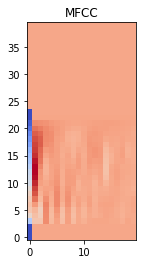

Doing thing 0/content/new_data1/0.wav
15


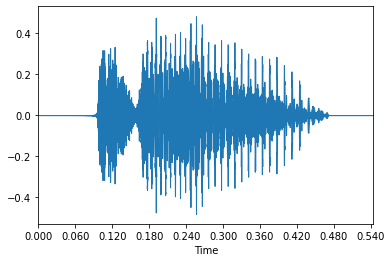

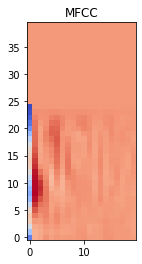

Doing thing 1/content/new_data1/1.wav
17


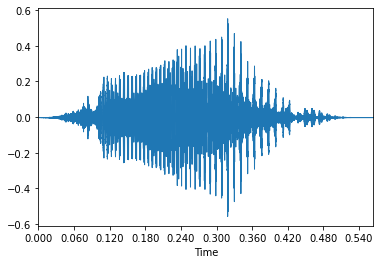

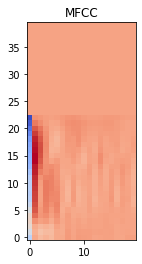

Doing thing 2/content/new_data1/2.wav
15


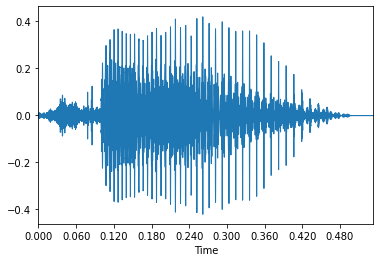

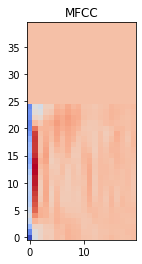

Doing thing 3/content/new_data1/3.wav
16


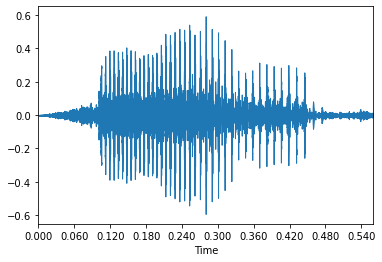

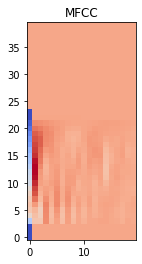

Doing thing 4/content/new_data1/4.wav
15


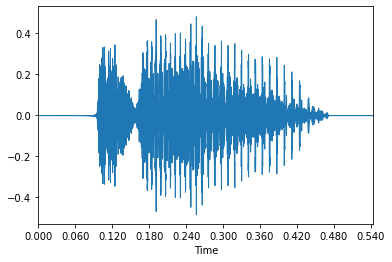

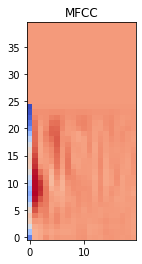

Doing thing 5/content/new_data1/5.wav
16


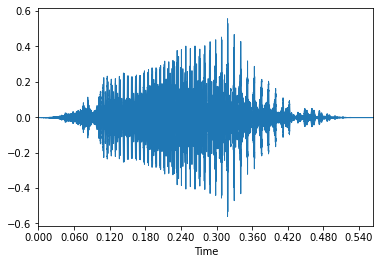

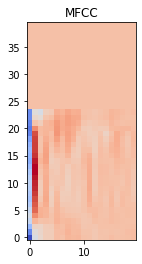

Doing thing 6/content/new_data1/6.wav
16


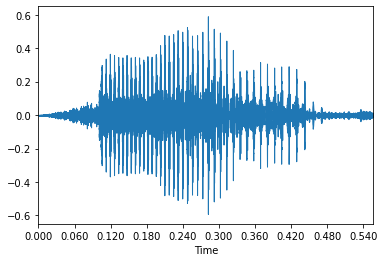

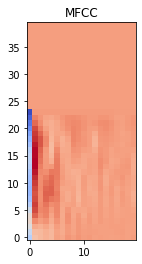

Doing thing 7/content/new_data1/7.wav
10


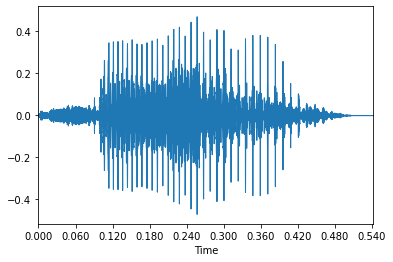

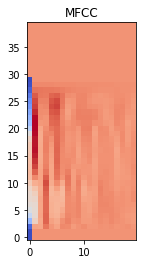

Doing thing 8/content/new_data1/8.wav
16


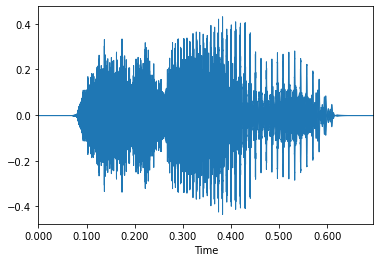

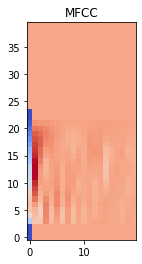

Doing thing 9/content/new_data1/9.wav
16


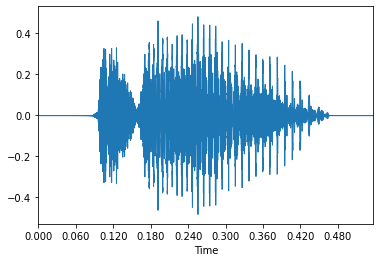

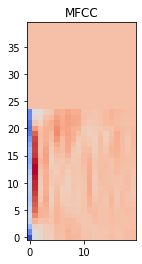

Doing thing 10/content/new_data1/10.wav
7


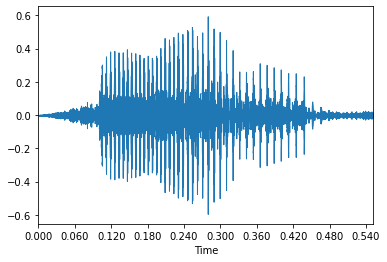

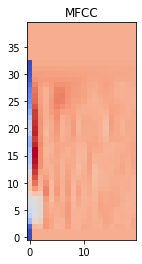

Doing thing 11/content/new_data1/11.wav
9


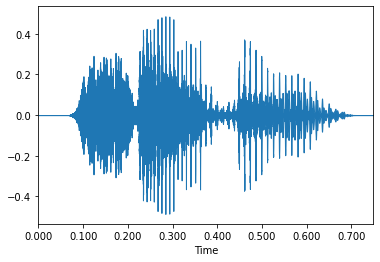

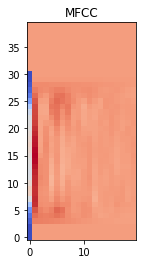

Doing thing 12/content/new_data1/12.wav
15


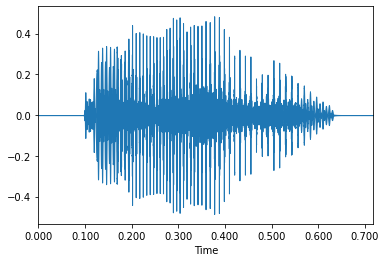

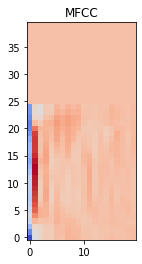

Doing thing 13/content/new_data1/13.wav
16


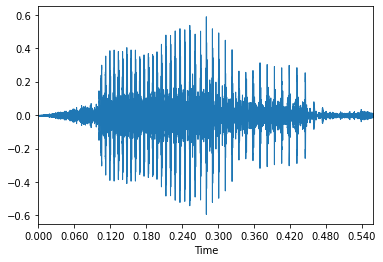

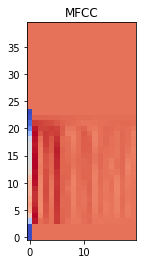

Doing thing 14/content/new_data1/14.wav
15


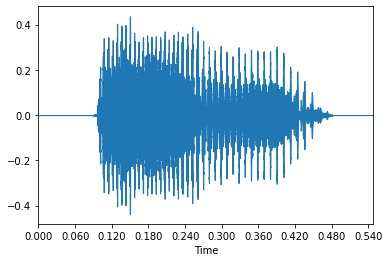

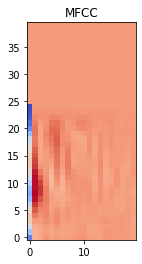

Doing thing 15/content/new_data1/15.wav
21


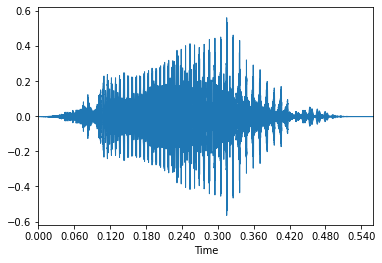

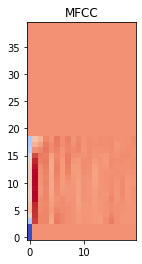

Doing thing 16/content/new_data1/16.wav
16


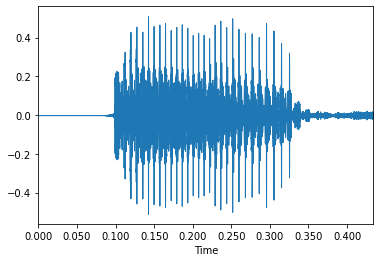

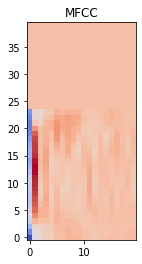

Doing thing 17/content/new_data1/17.wav
17


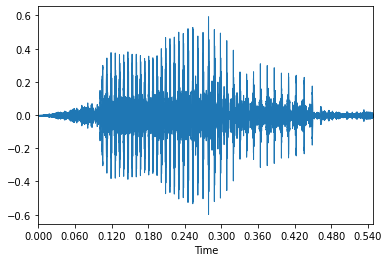

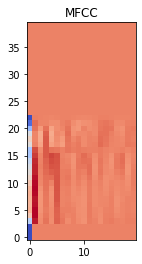

Doing thing 18/content/new_data1/18.wav
8


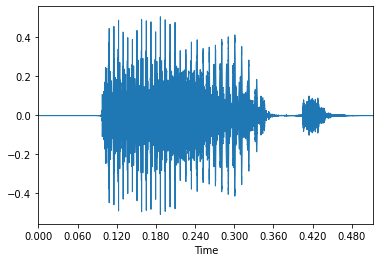

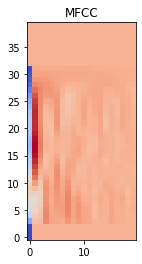

Doing thing 19/content/new_data1/19.wav
15


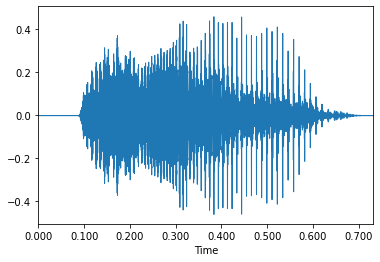

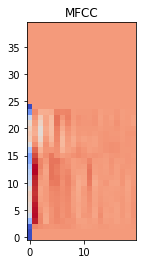

Doing thing 20/content/new_data1/20.wav
16


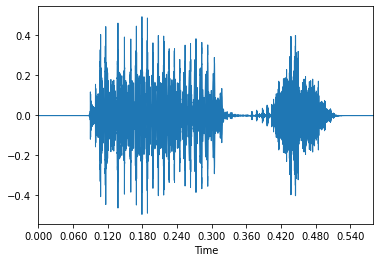

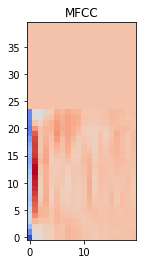

Doing thing 21/content/new_data1/21.wav
16


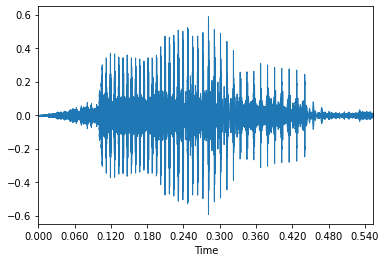

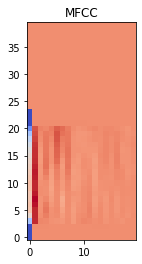

Doing thing 22/content/new_data1/22.wav
15


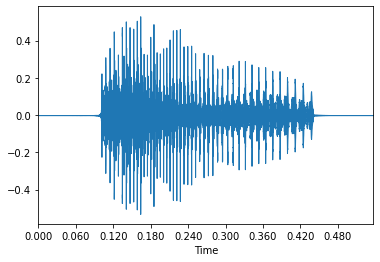

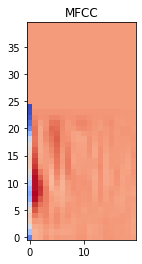

Doing thing 23/content/new_data1/23.wav
16


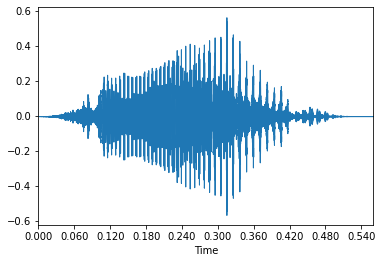

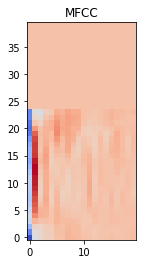

Doing thing 24/content/new_data1/24.wav
9


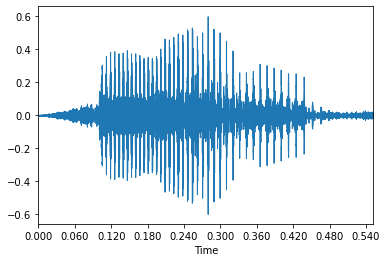

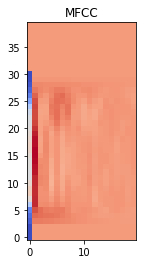

Doing thing 25/content/new_data1/25.wav
15


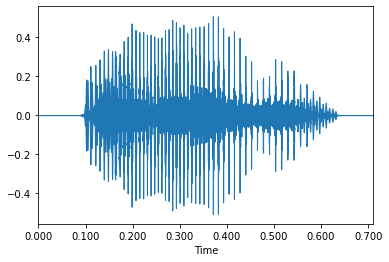

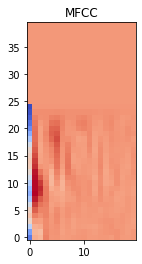

Doing thing 26/content/new_data1/26.wav
15


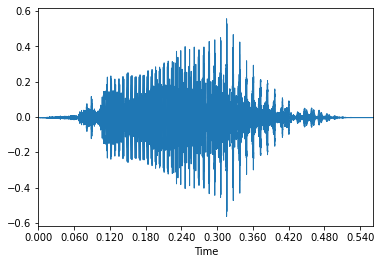

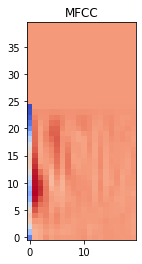

Doing thing 27/content/new_data1/27.wav
17


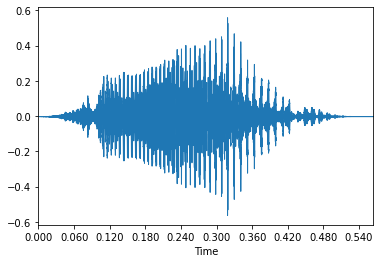

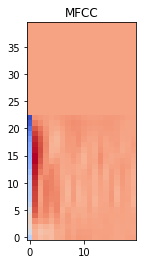

Doing thing 28/content/new_data1/28.wav
15


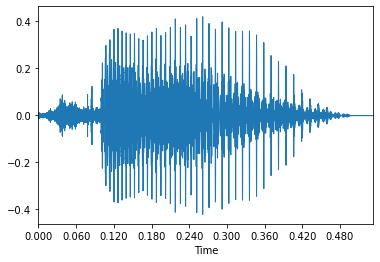

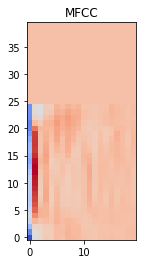

Doing thing 29/content/new_data1/29.wav
16


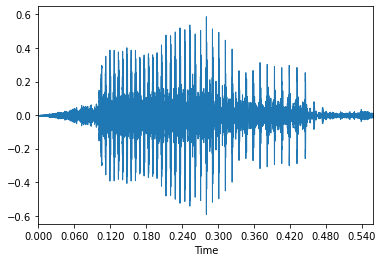

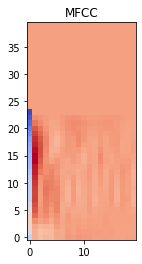

Doing thing 30/content/new_data1/30.wav
17


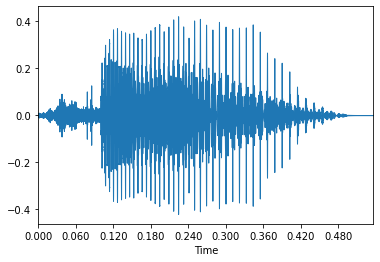

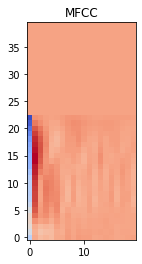

Doing thing 31/content/new_data1/31.wav
16


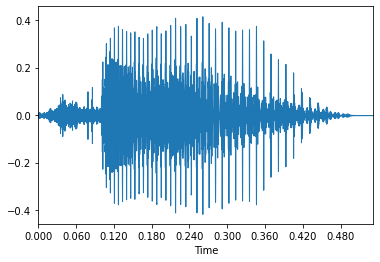

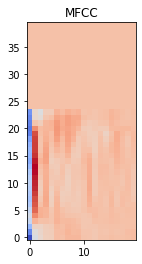

Doing thing 32/content/new_data1/32.wav
16


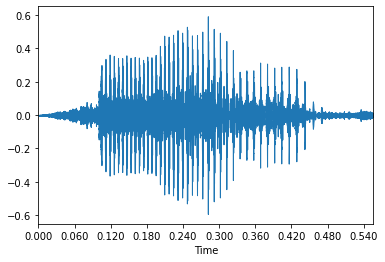

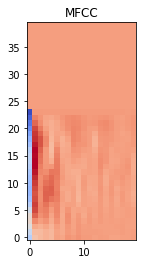

Doing thing 33/content/new_data1/33.wav
14


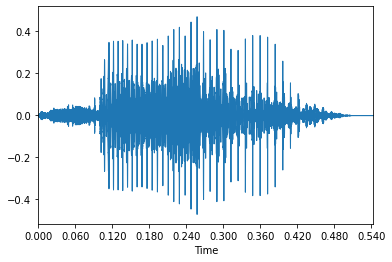

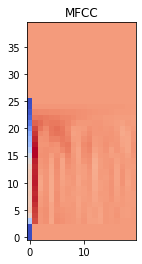

Doing thing 34/content/new_data1/34.wav
16


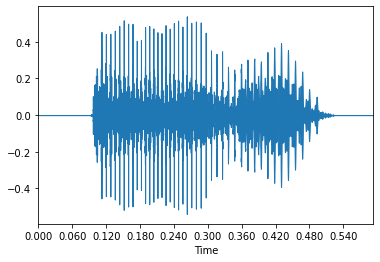

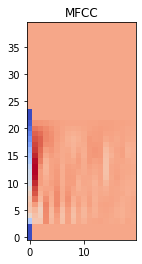

Doing thing 35/content/new_data1/35.wav
16


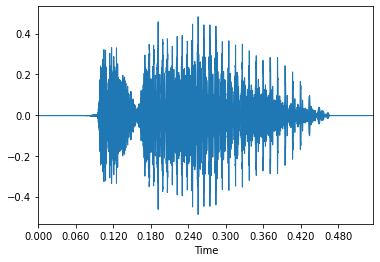

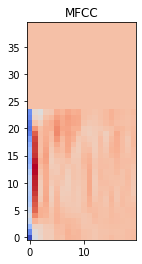

Doing thing 36/content/new_data1/36.wav
15


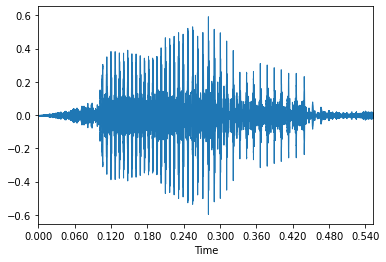

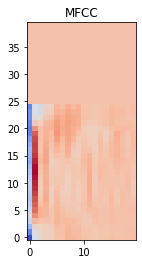

Doing thing 37/content/new_data1/37.wav
15


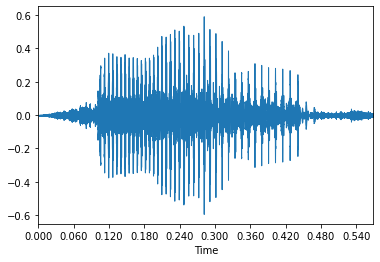

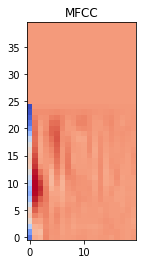

Doing thing 38/content/new_data1/38.wav
15


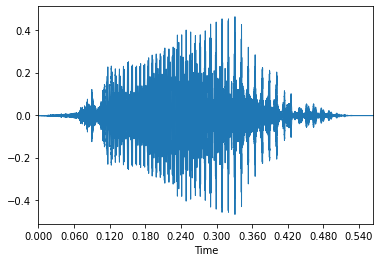

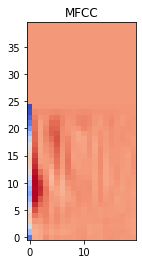

Doing thing 39/content/new_data1/39.wav
13


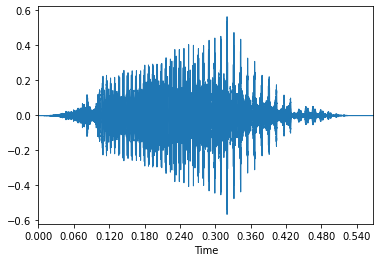

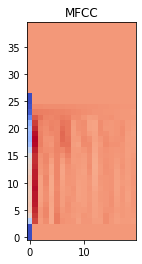

Doing thing 40/content/new_data1/40.wav
15


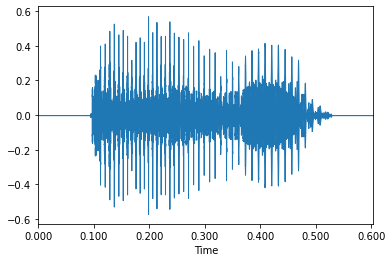

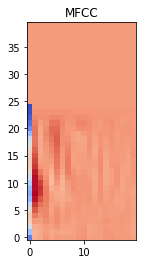

Doing thing 41/content/new_data1/41.wav
15


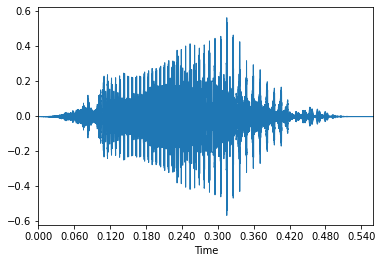

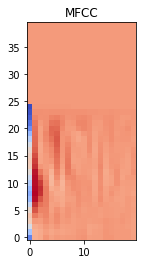

Doing thing 42/content/new_data1/42.wav
16


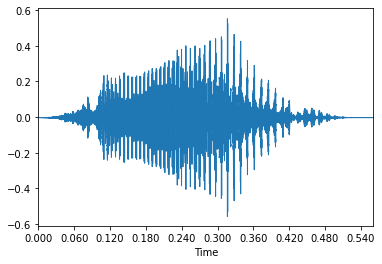

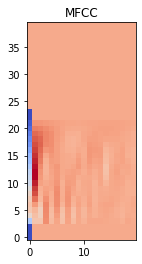

Doing thing 43/content/new_data1/43.wav
16


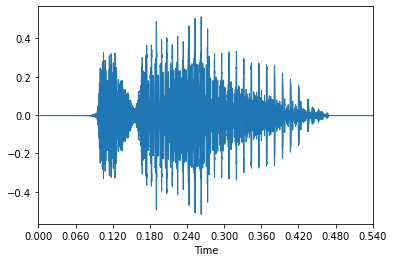

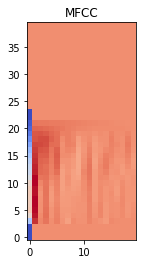

Doing thing 44/content/new_data1/44.wav
17


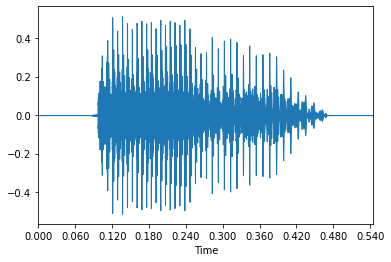

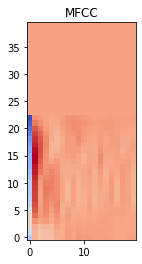

Doing thing 45/content/new_data1/45.wav
16


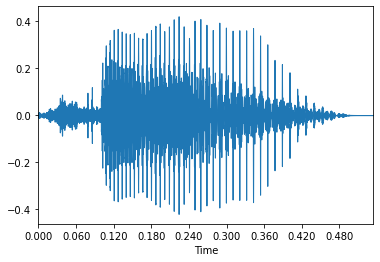

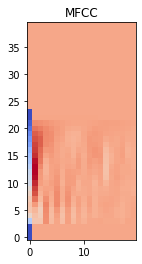

Doing thing 46/content/new_data1/46.wav
15


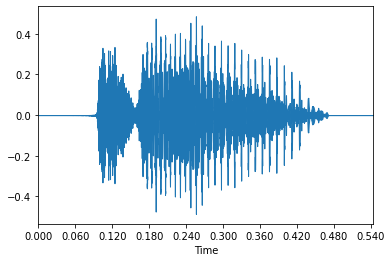

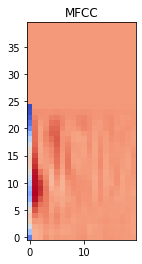

Doing thing 47/content/new_data1/47.wav
12


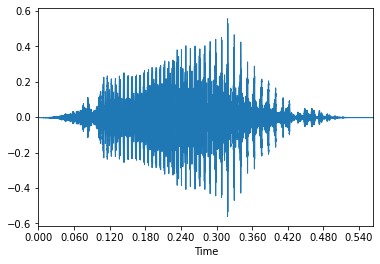

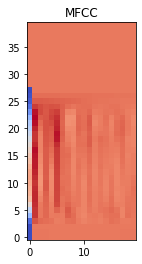

Doing thing 48/content/new_data1/48.wav
16


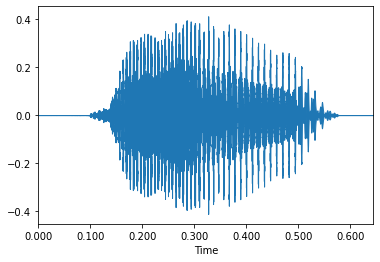

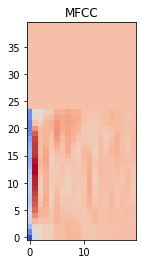

Doing thing 49/content/new_data1/49.wav
16


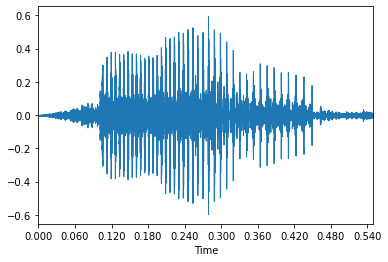

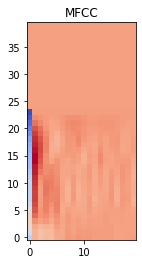

Doing thing 50/content/new_data1/50.wav
16


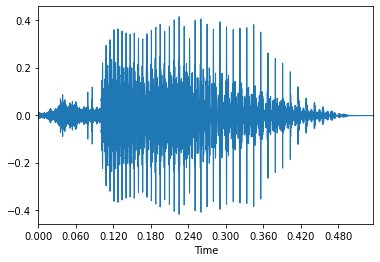

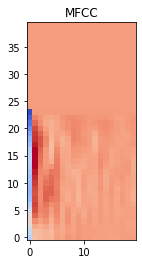

Doing thing 51/content/new_data1/51.wav
7


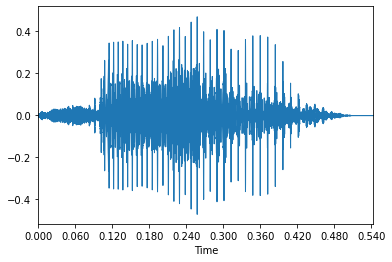

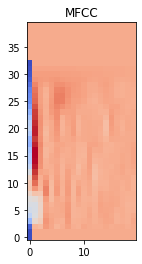

Doing thing 52/content/new_data1/52.wav
16


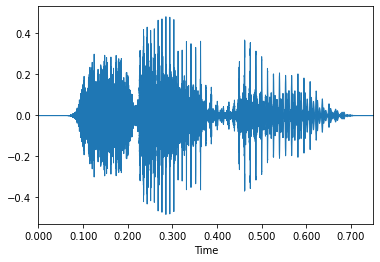

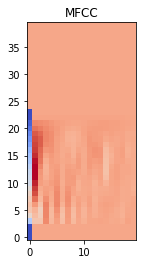

Doing thing 53/content/new_data1/53.wav
15


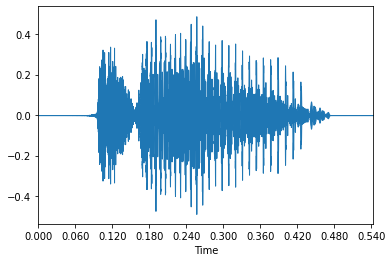

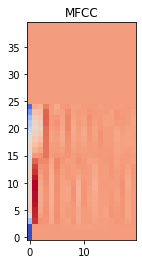

Doing thing 54/content/new_data1/54.wav
7


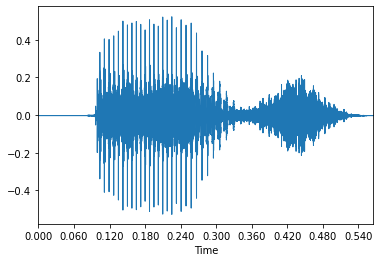

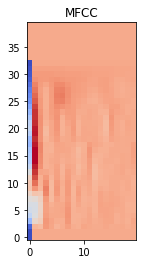

Doing thing 55/content/new_data1/55.wav
16


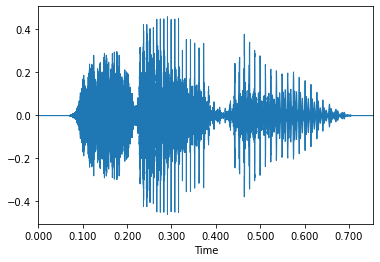

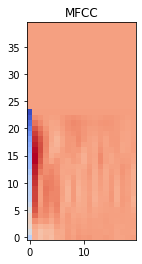

Doing thing 56/content/new_data1/56.wav
16


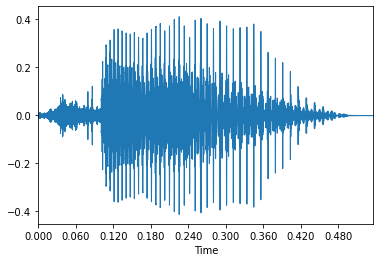

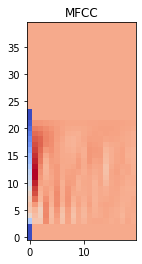

Doing thing 57/content/new_data1/57.wav
7


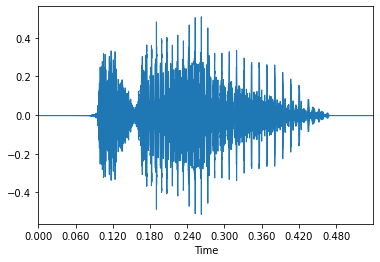

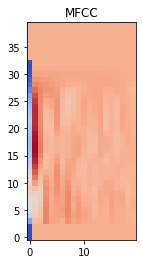

Doing thing 58/content/new_data1/58.wav
15


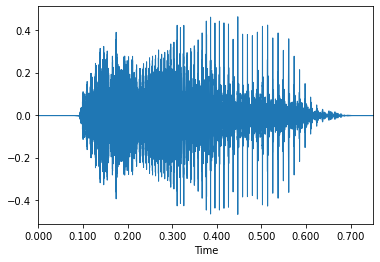

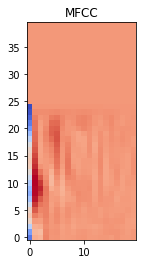

Doing thing 59/content/new_data1/59.wav
11


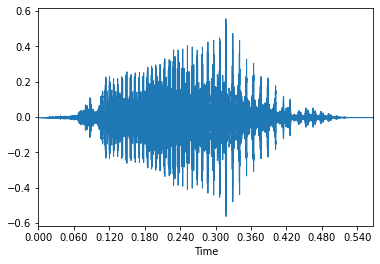

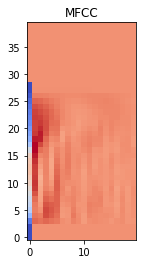

Doing thing 60/content/new_data1/60.wav
16


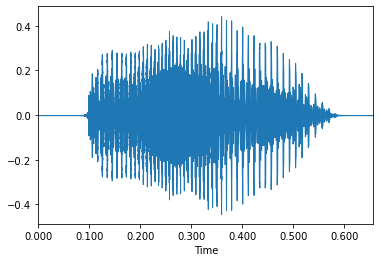

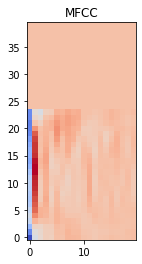

Doing thing 61/content/new_data1/61.wav
8


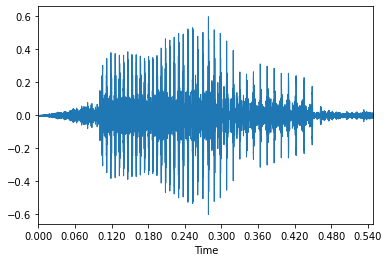

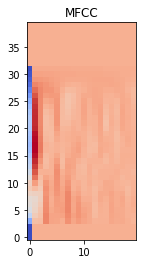

Doing thing 62/content/new_data1/62.wav
16


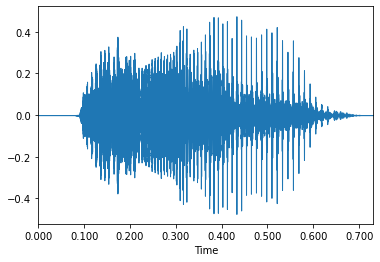

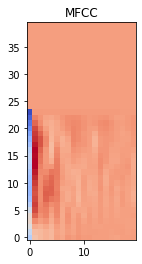

Doing thing 63/content/new_data1/63.wav
16


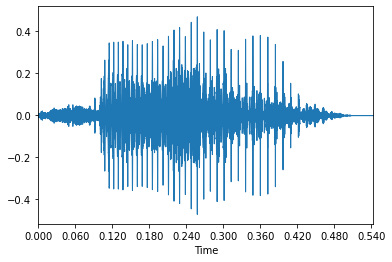

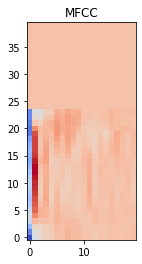

Doing thing 64/content/new_data1/64.wav
12


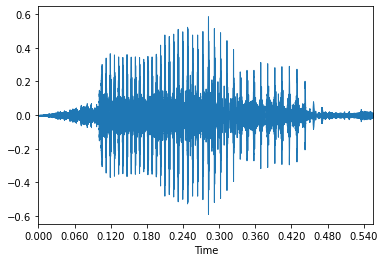

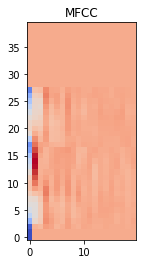

Doing thing 65/content/new_data1/65.wav
2


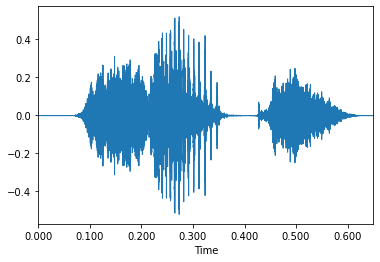

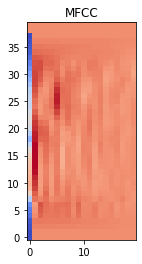

Doing thing 66/content/new_data1/66.wav
14


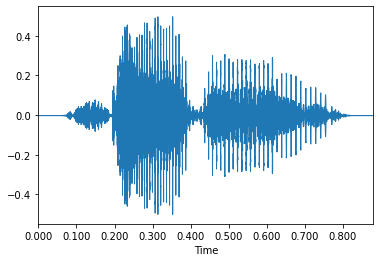

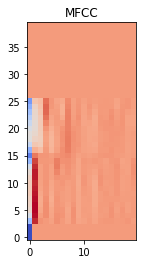

Doing thing 67/content/new_data1/67.wav
13


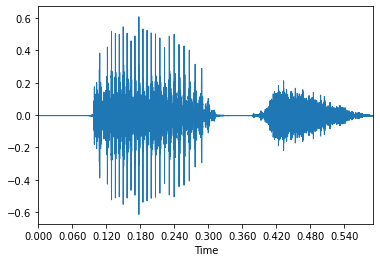

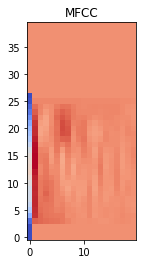

Doing thing 68/content/new_data1/68.wav
16


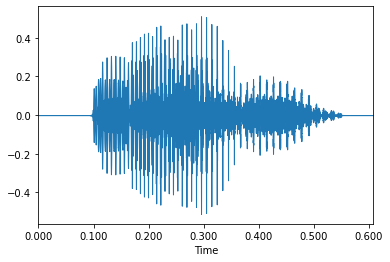

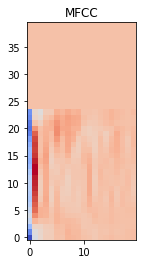

Doing thing 69/content/new_data1/69.wav
17


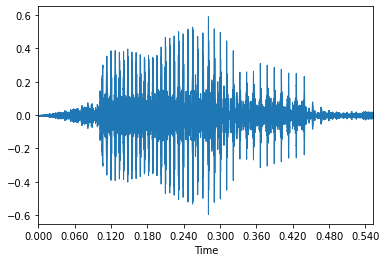

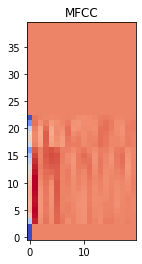

Doing thing 70/content/new_data1/70.wav
7


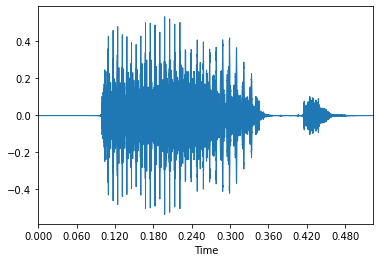

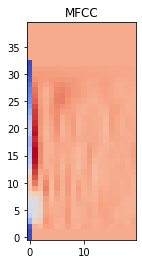

Doing thing 71/content/new_data1/71.wav
16


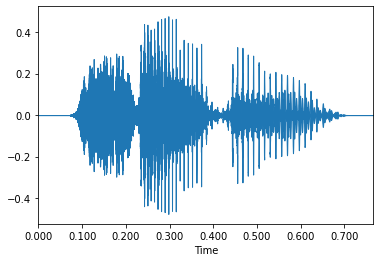

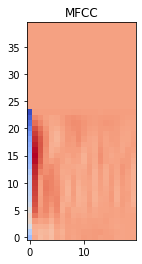

Doing thing 72/content/new_data1/72.wav
15


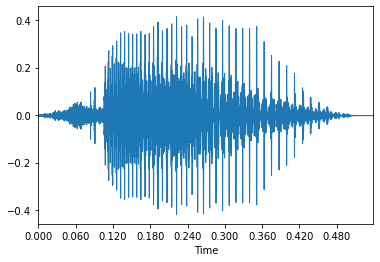

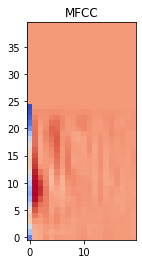

Doing thing 73/content/new_data1/73.wav
15


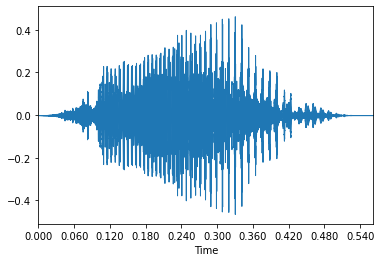

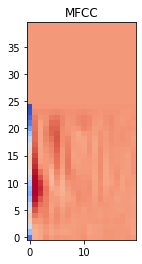

Doing thing 74/content/new_data1/74.wav
11


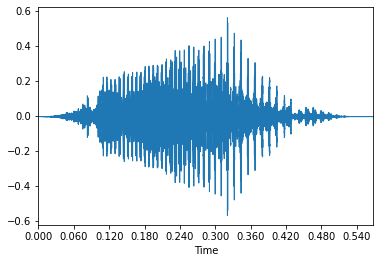

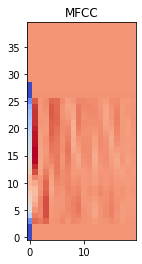

Doing thing 75/content/new_data1/75.wav
15


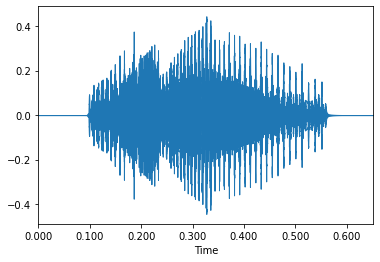

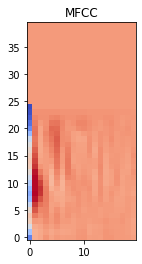

Doing thing 76/content/new_data1/76.wav
16


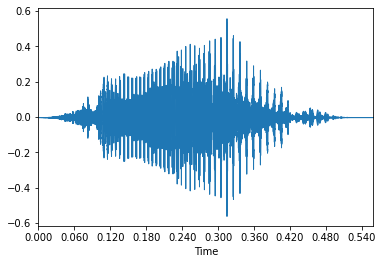

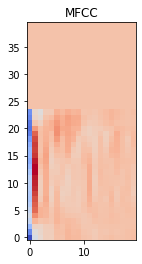

Doing thing 77/content/new_data1/77.wav
16


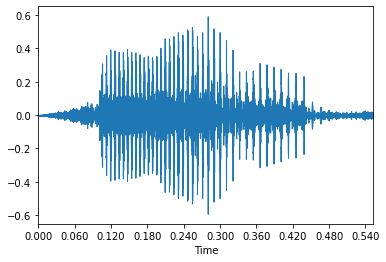

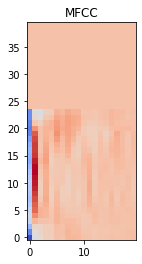

Doing thing 78/content/new_data1/78.wav
17


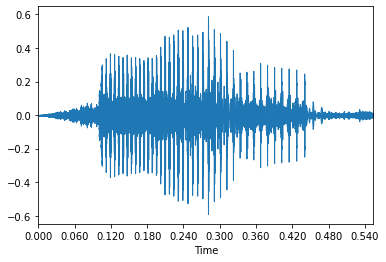

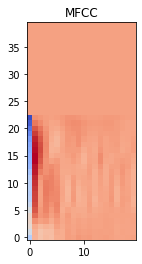

Doing thing 79/content/new_data1/79.wav
18


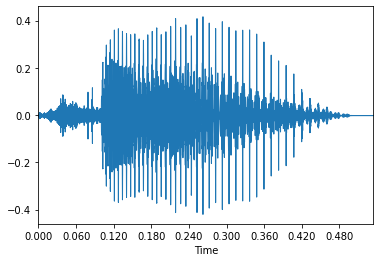

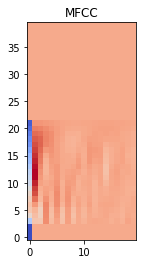

Doing thing 80/content/new_data1/80.wav


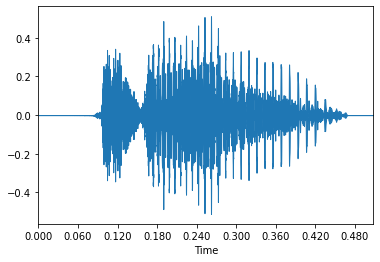

In [318]:
data_audio = dataset_new.get_data()

In [319]:
data_audio.shape

(81, 20, 40)

In [320]:
data_audio = data_audio.reshape(data_audio.shape[0],data_audio.shape[1],data_audio.shape[2],1)

In [321]:
final_test_preds = model.predict(data_audio)


In [344]:
final_test_preds[56].argmax()

0

In [345]:
final_test_preds.shape

(81, 10)

In [346]:
chunks1[56]

In [355]:
#dat,srr = librosa.load('/content/AudioMNIST/data/02/1_02_0.wav')
dat,srr = librosa.load('/content/new_data1/80.wav')
dat = nr.reduce_noise(y=dat, sr=srr)
#dat = dat[::1]
dat.shape

(11202,)

In [356]:
mfccX = librosa.feature.mfcc(dat, sr=8000)
mfccX.shape

(20, 22)

In [357]:
#AudioSegment.from_wav('/content/AudioMNIST/data/02/1_02_0.wav')
AudioSegment.from_wav('/content/new_data1/80.wav')

In [358]:
pad_widthX = 40 - mfccX.shape[1]
mfccX = np.pad(mfccX, pad_width=((0, 0), (0, pad_widthX)), mode='constant')
mfccX.shape

(20, 40)

In [359]:
mfccX = mfccX.reshape(mfccX.shape[0],mfccX.shape[1],1)
mfccX.shape

(20, 40, 1)

In [360]:
da = []
da.append(mfccX)
npd = np.asarray(da)
del da

In [361]:
testp  = model.predict(npd)
testp.shape

(1, 10)

In [362]:
testp.argmax()

2